In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve

In [107]:
df = pd.read_csv('train.csv', index_col=0)
df.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,,
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


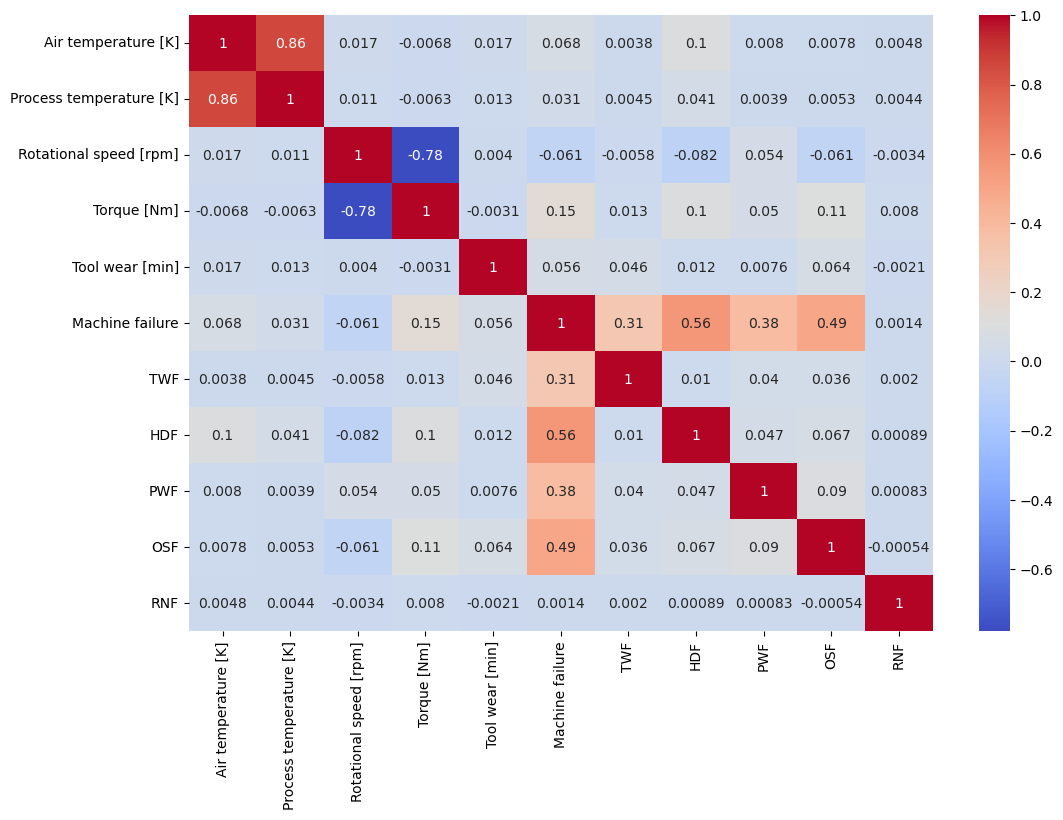

In [60]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [108]:
df['power [kW]'] = (2 * math.pi * df['Rotational speed [rpm]'] * df['Torque [Nm]']) / 60

In [109]:
df = df.drop(['Product ID', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'RNF'], axis=1)

In [110]:
df.head()

,Type,Air temperature [K],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,power [kW]
id,,,,,,,,,
0,L,300.6,140,0,0,0,0,0,6033.491523
1,M,302.6,200,0,0,0,0,0,5360.279633
2,L,299.3,25,0,0,0,0,0,5009.007687
3,L,301.0,197,0,0,0,0,0,7069.965771
4,M,298.0,34,0,0,0,0,0,6083.317183


In [96]:
for column in df.columns:
    value_counts = df[column].value_counts()
    print(f"Column: {column}")
    print(value_counts)
    print('============================') 

Column: Type
L    95354
M    32152
H     8923
Name: Type, dtype: int64
Column: Air temperature [K]
300.700    4984
297.400    4042
300.500    3707
300.600    3584
298.200    3419
           ... 
295.400      10
295.300       4
300.980       1
297.095       1
303.960       1
Name: Air temperature [K], Length: 95, dtype: int64
Column: Tool wear [min]
0      3790
2      1771
119    1448
59     1427
5      1419
       ... 
241       7
237       6
239       6
253       3
251       1
Name: Tool wear [min], Length: 246, dtype: int64
Column: Machine failure
0    134281
1      2148
Name: Machine failure, dtype: int64
Column: TWF
0    136217
1       212
Name: TWF, dtype: int64
Column: HDF
0    135725
1       704
Name: HDF, dtype: int64
Column: PWF
0    136102
1       327
Name: PWF, dtype: int64
Column: OSF
0    135889
1       540
Name: OSF, dtype: int64
Column: power [kW]
8502.196918    51
5854.483574    43
5396.491725    37
6095.946385    37
6079.819543    37
               ..
6923.536138     1

In [111]:
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

df.head()

,Air temperature [K],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,power [kW],Type_L,Type_M
id,,,,,,,,,,
0,300.6,140,0,0,0,0,0,6033.491523,1,0
1,302.6,200,0,0,0,0,0,5360.279633,0,1
2,299.3,25,0,0,0,0,0,5009.007687,1,0
3,301.0,197,0,0,0,0,0,7069.965771,1,0
4,298.0,34,0,0,0,0,0,6083.317183,0,1


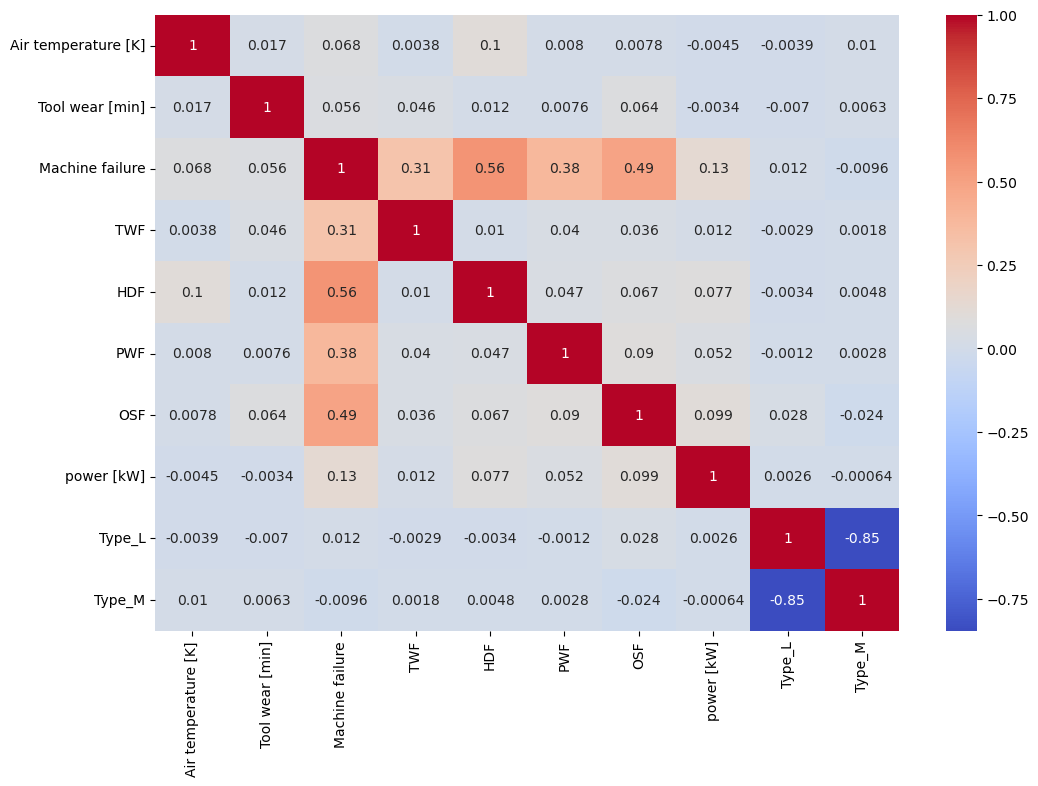

In [115]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

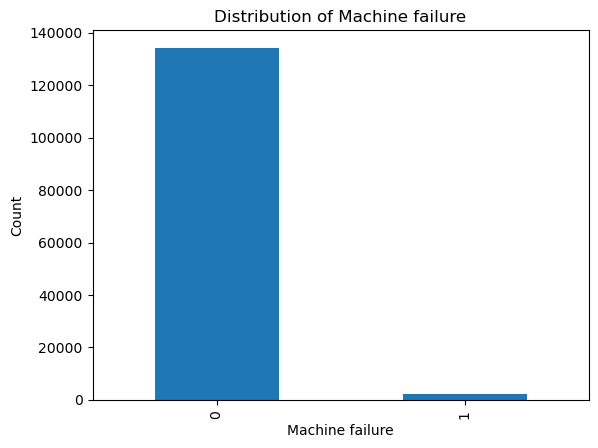

In [116]:
df['Machine failure'].value_counts().plot(kind='bar')
plt.title('Distribution of Machine failure')
plt.xlabel('Machine failure')
plt.ylabel('Count')
plt.show()

In [117]:
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [118]:
# sm = SMOTE(random_state=42)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Check the distribution of target after SMOTE
# pd.Series(y_train).value_counts().plot(kind='bar')
# plt.title('Distribution of Machine failure')
# plt.xlabel('Machine failure')
# plt.ylabel('Count')
# plt.show()

In [119]:
model = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'bootstrap': [True]
}

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

y_pred_proba = random_search.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC ： {roc_auc}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
AUC ： 0.9491603925498391


In [120]:
best_params = random_search.best_params_
best_score = random_search.best_score_

best_params, best_score

({'n_estimators': 100,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_depth': 10,
  'bootstrap': True},
 0.9961884866642844)

In [121]:
y_pred = random_search.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)

precision = precision_score(y_test, y_pred)

recall = recall_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

ariables = {'cm': cm, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

for variable, value in variables.items():
    print(f"{variable} = {value}")

cm = [[25854   994]
 [   87   351]]
accuracy = 0.96038261379462
precision = 0.26096654275092934
recall = 0.8013698630136986
f1 = 0.39371845204711164
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  13.2s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   8.1s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=  22.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  41.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=  43.9s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=  35.0s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  22.0s
[CV] END bootstrap=True, max_

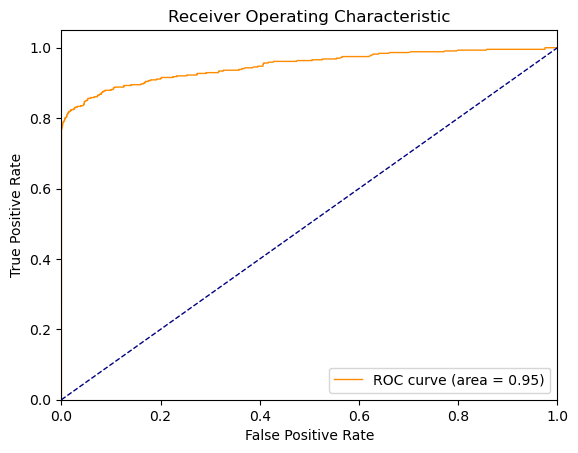

In [160]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [156]:
y_pred_05 = (y_pred_proba >= 0.5).astype(int)

cm_05 = confusion_matrix(y_test, y_pred_05)
accuracy_05 = accuracy_score(y_test, y_pred_05)
precision_05 = precision_score(y_test, y_pred_05)
recall_05 = recall_score(y_test, y_pred_05)
f1_05 = f1_score(y_test, y_pred_05)

print(f"cm_05 : {cm_05}")
print(f"accuracy_05 : {accuracy_05}")
print(f"precision_05 : {precision_05}")
print(f"recall_05 : {recall_05}")
print(f"f1_05 : {f1_05}")

cm_05 : [[26846     2]
 [  102   336]]
accuracy_05 : 0.9961885215861614
precision_05 : 0.9940828402366864
recall_05 : 0.7671232876712328
f1_05 : 0.865979381443299


In [209]:
test = pd.read_csv('test.csv', index_col=0)
test.head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
id,,,,,,,,,,,,
136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0


In [210]:
test['power [kW]'] = (2 * math.pi * test['Rotational speed [rpm]'] * test['Torque [Nm]']) / 60
test = test.drop(['Product ID', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'RNF'], axis=1)
test = pd.get_dummies(test, columns=['Type'], drop_first=True)
test.head()

,Air temperature [K],Tool wear [min],TWF,HDF,PWF,OSF,power [kW],Type_L,Type_M
id,,,,,,,,,
136429,302.3,60,0,0,0,0,5965.046691,1,0
136430,301.7,17,0,0,0,0,5166.286287,1,0
136431,301.3,96,0,0,0,0,6020.600521,1,0
136432,300.1,5,0,0,0,0,7372.312648,0,1
136433,303.4,114,0,0,0,0,6552.262718,0,1


In [211]:
test['Machine failure'] = (random_search.predict_proba(test)[:, 1] >= 0.8).astype(int)
test.head()

,Air temperature [K],Tool wear [min],TWF,HDF,PWF,OSF,power [kW],Type_L,Type_M,Machine failure
id,,,,,,,,,,
136429,302.3,60,0,0,0,0,5965.046691,1,0,0
136430,301.7,17,0,0,0,0,5166.286287,1,0,0
136431,301.3,96,0,0,0,0,6020.600521,1,0,0
136432,300.1,5,0,0,0,0,7372.312648,0,1,0
136433,303.4,114,0,0,0,0,6552.262718,0,1,0


In [212]:
test.reset_index(drop=False, inplace=True)
test.head()

,id,Air temperature [K],Tool wear [min],TWF,HDF,PWF,OSF,power [kW],Type_L,Type_M,Machine failure
0,136429,302.3,60,0,0,0,0,5965.046691,1,0,0
1,136430,301.7,17,0,0,0,0,5166.286287,1,0,0
2,136431,301.3,96,0,0,0,0,6020.600521,1,0,0
3,136432,300.1,5,0,0,0,0,7372.312648,0,1,0
4,136433,303.4,114,0,0,0,0,6552.262718,0,1,0


In [215]:
test[['id', 'Machine failure']].to_csv('submission2.csv', index=False)